In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import numpy as np

Load IDs of species

In [4]:
species_id = pd.read_csv("../data/sample_genus_and_species.csv", header=None, 
                         names = ["sample", 'genus', 'species'], index_col = 0)

In [13]:
! aws s3 ls s3://czbiohub-mosquito/references/sourmash/comparison/

2018-08-15 17:36:24       2000 k21.csv
2018-08-17 15:19:56     146080 k21abun.csv
2018-08-15 17:35:38       2003 k31.csv
2018-08-17 15:21:10     148533 k31abun.csv
2018-08-15 17:35:28       2009 k51.csv
2018-08-17 15:23:39     148157 k51abun.csv


In [18]:
k21sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k21abun.csv")
k31sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k31abun.csv")
k51sim = pd.read_csv("s3://czbiohub-mosquito/references/sourmash/comparison/k51abun.csv")

In [19]:
for sim in [k21sim, k31sim, k51sim]:
    sim.index = sim.columns
    sim.columns = species_id.loc[sim.columns.tolist()]['species'].values

/Users/josh/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


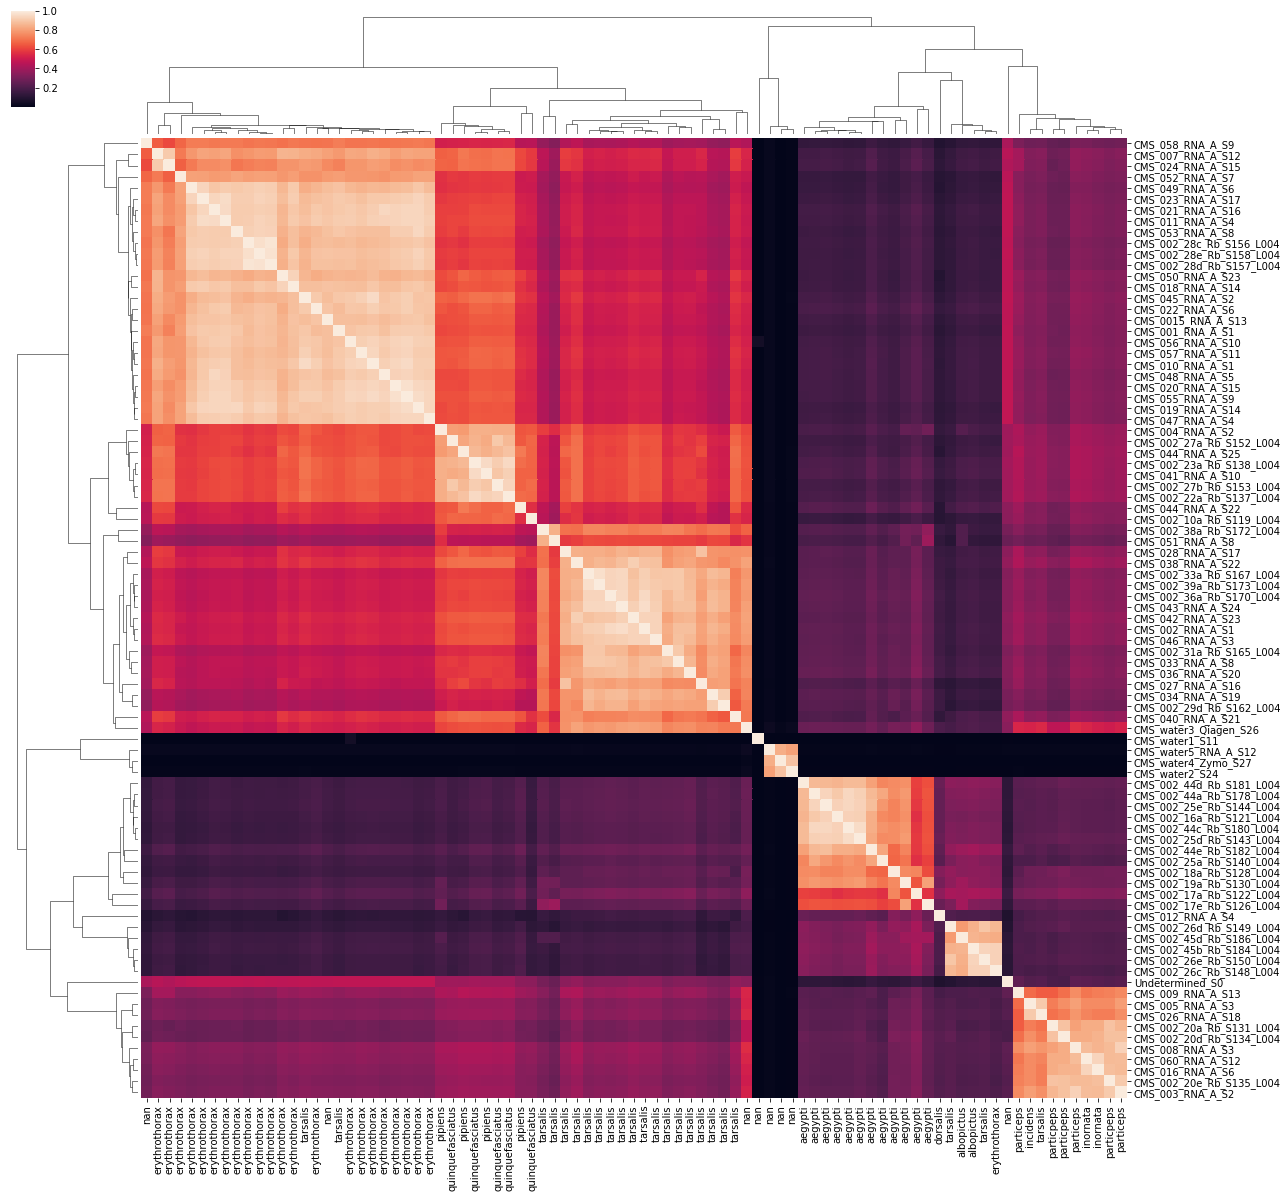

In [24]:
sns.clustermap(k31sim,  figsize = (20,20))

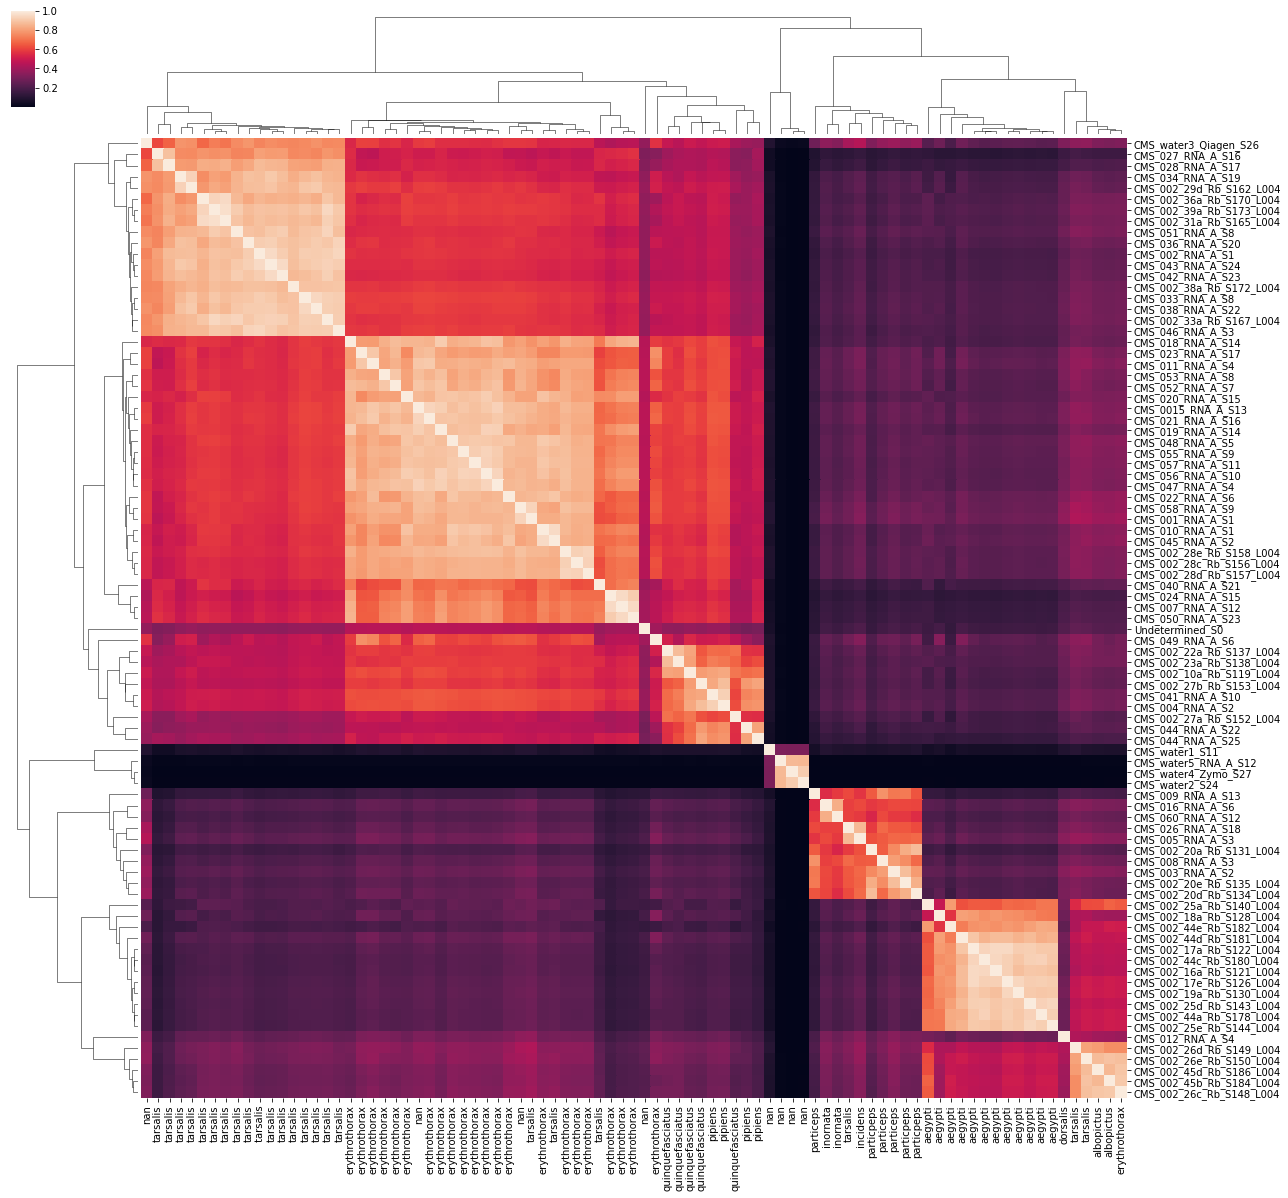

In [25]:
sns.clustermap(k51sim,  figsize = (20,20))

There does seem to be some discordance between between labels and this clustering, and also between this clustering and lucy's COI analysis